In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import os

EventTypes = {'noType': 0, 'sessionStart': 1, 'sessionEnd': 2, 'gameStart': 3, 'gameEnd': 4, 'roundStart': 5, 'cardStateChange': 6}
CardStates = {'left': 0, 'right': 1, 'center': 2, 'dropped': 3}

directory = '../Data/'

dfs = []

#cargamos todos los archivos del directorio Data
for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    #hay que comprobar que son archivos
    if os.path.isfile(filepath):
        df = pd.read_json(filepath, lines=True)
        dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

display(data)

,EventType,TimeStamp,CardState,Win
0,1,2024-04-26 10:27:44.104,NaN,NaN
1,3,2024-04-26 10:28:19.740,NaN,NaN
2,6,2024-04-26 10:29:14.688,2.0,NaN
3,6,2024-04-26 10:29:14.752,1.0,NaN
4,5,2024-04-26 10:29:14.849,NaN,NaN
...,...,...,...,...
1524,6,2024-04-26 11:12:59.648,2.0,NaN
1525,6,2024-04-26 11:12:59.694,1.0,NaN
1526,5,2024-04-26 11:12:59.831,NaN,NaN
1527,4,2024-04-26 11:13:00.072,NaN,0.0


MEDIA DE TIEMPO ENTRE RONDAS: 	 6.395468992248062


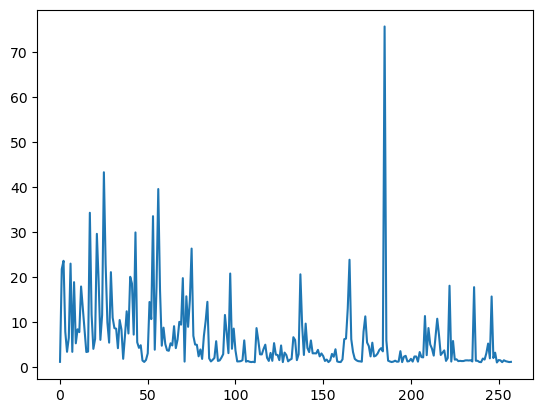

In [2]:
#METRICA: TIEMPO MEDIO EN CADA PREGUNTA

# filtramos solo los eventos de roundStart y gameEnd del dataframe

# se utilizan tambien los eventos de tipo 'gameEnd' ya que hay que calcular diferencias de timeStamps
# y no existe roundEnd para la última ronda de la partida
rounds = data[(data['EventType'] == EventTypes['roundStart']) | (data['EventType'] == EventTypes['gameEnd'])]

# reseteamos el indice para luego cogerlos
rounds = rounds.reset_index(drop=True)

# aqui se calcula la diferencia de cada fila con la anterior, lo que obtiene la diferencia de tiempos 
# entre cada roundStart y gameEnd
rounds['TimeDiff'] = rounds['TimeStamp'].diff()

# quitamos los tiempos que vienen despues de un gameEnd, pues hasta que inicia la ronda hay que ver 
# toda la cinemática inicial y contamina los datos

# este codigo coge todos los índices de filas de eventos 'gameEnd' y borra todos los eventos siguientes 
# (por eso el indices + 1), además no coge el último gameEnd porque después de este no se incia una ronda al salir del juego
indices = rounds[(rounds['EventType'] == EventTypes['gameEnd'])]['TimeDiff'].index
rounds = rounds.drop((indices + 1)[:-1])

# cogemos únicamente la columna de TimeDiff de los eventos roundStart y lo pasamos a numpy
timeDiffs = rounds[(rounds['EventType'] == EventTypes['roundStart'])]['TimeDiff']
timeDiffsArray = (timeDiffs.to_numpy()[1:]).astype(float) * 1e-9
media = timeDiffsArray.mean()

# dibujamos la gráfica con todos los tiempos de cada ronda
plt.plot(timeDiffsArray)

print('MEDIA DE TIEMPO ENTRE RONDAS: \t', media)

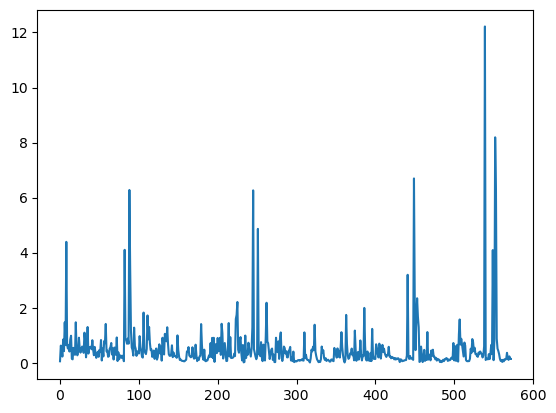

MEDIA DE TIEMPO QUE SE MANTIENE UNA CARTA A UN LADO: 	 0.5114816753926703


In [3]:
#METRICA: TIEMPO MEDIO QUE SE MANTIENE UNA CARTA EN CUALQUIERA DE LOS LADOS

# filtramos solo los eventos de cambio de estado de las cartas
cardsOnSide = data[(data['EventType'] == EventTypes['cardStateChange']) | (data['EventType'] == EventTypes['roundStart'])]

# reseteamos el índice para poder trabajar con ellos luego
cardsOnSide = cardsOnSide.reset_index(drop=True)

# calculamos la diferencia de tiempos entre cada evento de este tipo
cardsOnSide['TimeDiff'] = cardsOnSide['TimeStamp'].diff()

# para calcular el tiempo que se mantiene a un lado la carta hay que ver: 
# 1. La diferencia de tiempo entre que la carta esté a la derecha o a la izquierda y el siguiente estado de esta 
# (que será siempre de tipo 'center')
# 2. La diferencia de tiempo entre que la carta esté a la derecha o a la izquierda y el fin la ronda

# este codigo coge los indices de los eventos de estado de la carta que sean 'right' o 'left' y avanza el índice para quedarse
# con la diferencia de tiempo desde que comenzó a estar en uno de los lados y la vuelta al centro o cambio de ronda
# se utiliza iloc para filtrar las filas, en este caso no supone problema de rendimiento
indices = cardsOnSide[(cardsOnSide['CardState'] == CardStates['right']) | (cardsOnSide['CardState'] == CardStates['left'])].index
cardsOnSide = cardsOnSide.iloc[(indices + 1)]

# cogemos la diferencia de tiempos y la pasamos a numpy
timeDiffs = cardsOnSide['TimeDiff']
timeDiffsArray = (timeDiffs.to_numpy()[1:]).astype(float) * 1e-9
media = timeDiffsArray.mean()

# dibujamos el tiempo que se mantiene una carta a cada lado cada vez
plt.plot(timeDiffsArray)
plt.show()

print('MEDIA DE TIEMPO QUE SE MANTIENE UNA CARTA A UN LADO: \t', media)

MEDIA DE VECES QUE SE ALTERNA DE LADOS POR RONDA:  0.8218181818181818
PORCENTAJE DE RONDAS EN LAS QUE SE ALTERNA DE LADOS:  29.454545454545457 %


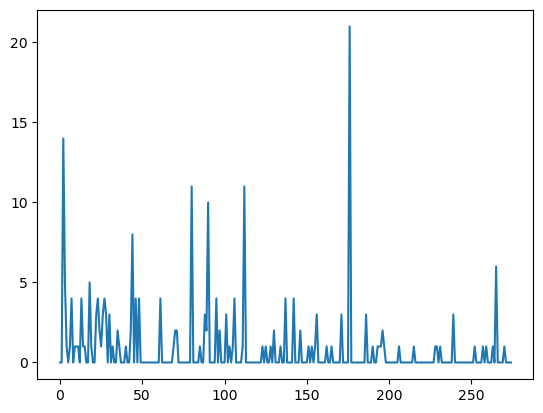

In [4]:
#METRICAS: MEDIA DE VECES QUE SE ALTERNA A DERECHA E IZQUIERDA UNA CARTA 
#Y PORCENTAJE DE RONDAS EN LAS QUE SE ALTERNA DE DERECHA A IZQUIERDA

#diccionario para poder saber que indice del ndarray es cada parametro del dataframe
dataframeDict = {'EventType' : 0, 'TimeStamp': 1, 'CardState': 2, 'Win': 3}

cardsAlternated = data[(data['EventType'] == EventTypes['roundStart'])| (data['EventType'] == EventTypes['cardStateChange'])]

cardsAlternatedArray = cardsAlternated.to_numpy()

n_rounds = 0
rounds_alternated = 0
n_alternated = 0
left = False
right = False
alternated_this_round = False
n_alternated_this_round = 0
# lista que representa las veces que se alterna en cada ronda
alternated_per_round = []

for i in range(len(cardsAlternated)):
    current_event_type = cardsAlternatedArray[i][dataframeDict['EventType']]
    
    #evento de inicio de ronda
    if current_event_type == 5:
        n_rounds += 1
        if alternated_this_round:
            rounds_alternated += 1
        alternated_this_round = False
        
        alternated_per_round.append(n_alternated_this_round)
        n_alternated_this_round = 0
        
        right = False
        left = False
    else:
        current_card_state = cardsAlternatedArray[i][dataframeDict['CardState']]
        
        if current_card_state == 0:
            left = True
        elif current_card_state == 1:
            right = True

        if left and right:
            alternated_this_round = True
            n_alternated += 1
            n_alternated_this_round += 1
            
            if current_card_state == 0:
                right = False
            elif current_card_state == 1:
                left = False
            
plt.plot(alternated_per_round)
print('MEDIA DE VECES QUE SE ALTERNA DE LADOS POR RONDA: ', n_alternated/n_rounds)
print('PORCENTAJE DE RONDAS EN LAS QUE SE ALTERNA DE LADOS: ', rounds_alternated/n_rounds * 100, '%')

# Conclusiones

## Hipótesis 1

La media de tiempo que se mantiene una carta a un lado es de 0.51 segundos. Viendo la gráfica vemos que hay veces que la carta se mantiene más tiempo a un lado, seguramente porque el jugador esté valorando los cambios que produce la decisión. 

En general, parece que el jugador medio no valora demasiado los cambios, o sabe con seguridad qué puede cambiar al tomar la decisión porque entiende que la derecha significa 'Sí' o 'Aceptar' y la izquierda 'No' o 'Rechazar'.

## Hipótesis 2

El jugador ve las 2 posibilidades de la decisión en un 29% de las veces, por lo que, por lo general, no valora ambas opciones en una pregunta. También puede ser que suponga la respuesta, como hemos dicho anteriormente, y no se tome el tiempo de ver qué recursos cambiarían en cada caso.

Además, el dato de la media de veces que se alterna refleja que se suele alternar menos de una vez por ronda. En la gráfica, sin embargo se ve que en alguna pregunta se alterna una cantidad muy grande de veces, seguramente porque dicha pregunta no se entiende correctamente o necesita valorar mucho la respuesta para no perder o controlar un recurso.

Podemos concluir, que por regla general el jugador no alterna en la mayoría de rondas. Esto se puede deber a que asume las consecuencias de la respuestas o mira solo un lado y predice que el lado contrario variará los recurso de forma opuesta.

## Hipótesis 3

La media de tiempo que pasan los jugadores en una ronda es de 6.39 segundos. Esta media refleja que en general, el jugador se toma su tiempo para leer al menos la propuesta actual.

En la gráfica observamos que hay picos de tiempo de unos 20s, que puede indicar preguntas más largas o más complejas, en las que el jugador dedica más tiempo a intentar entender la pregunta o ver las opciones que tiene.

Los datos indican que el jugador medio sí dedica un poco de tiempo a cada pregunta, tardando más en algunas puntualmente.

## Objetivo 1: Comprobar que los jugadores ven la información de los recursos que suben y bajan

Podemos deducir a ráiz de los datos recogidos y de las hipótesis 1 y 2 que el jugador medio no mira los recursos que suben y bajan por regla general, lo hace sólo en momentos puntuales.

Esto se puede deber a diversos factores:

- El jugador desconoce que se puede ver qué recursos cambian.

- La mayoría de las preguntas no son lo suficientemente complejas como para requerir un análisis detenido de los recursos que suben y bajan. Sólo en algunas preguntas el jugador tiene que mirarlos detenidamente porque no sabe cuál será el resultado.

- El jugador ve que los recursos bajan drásticamente y se detiene a analizar para intentar arreglar sus fallos anteriores.

Estos datos indican también que pueden existir preguntas que no se entiendan bien, porque se dedica mucho tiempo algunas veces.

## Objetivo 2: Comprobar que los jugadores razonan cada pregunta antes de tomar una decisión

Aunque hemos visto que el jugador no suele mirar los recurso que van a cambiar, si parece que se tome su tiempo para leer la pregunta y pensar qué puede ocasionar su respuesta.

Parece ser que el jugador medio se guía por una heurística propia, no por los datos que le proporciona el juego. 

Tambien se aprecia que hay preguntas significativamente más complejas, en las que el jugador se detiene mucho más tiempo. Puede ser que dichas preguntas no se entiendan bien, porque no sean de respuesta 'Sí' o 'No'.